Load Data

In [1]:
import torch
from torch_geometric.data import Data
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import sys
sys.path.append('/Volumes/Lab/Users/bhofflic/cell_classification/src/')
import file_handling
import cell_display_lib as cdl
import pickle

path ='/Volumes/Scratch/Users/bhofflic/cell_correlations/gnn_data/'

Load Data

In [2]:
# Load all pickle files in path
import glob

data = pd.DataFrame()
files = glob.glob(path+'*.pkl')
for file in tqdm(files):
    if file[-12:] == 'gnn_data.pkl':
        continue
    with open(file, 'rb') as f:
        data = pd.concat([data,pickle.load(f)])

100%|██████████| 19/19 [03:14<00:00, 10.24s/it]


Preprocessing

In [3]:
# Define the ruleout types
ruleout = ['BW', 'unlabel', 'weird', 'duplicate', 'unclass', 'contaminated', 'crap', 'edge', 'weak', 'mess', 'Unclass', 'artifact']

# Preprocessing: Filter out unwanted cell types
# Create a mask for valid cell types
labels = data['label'].values
valid_cell_mask = ~np.isin(labels, ruleout)
all_data = data[valid_cell_mask]

In [4]:
focus_types = ['ON parasol', 'OFF parasol', 'ON midget', 'OFF midget', 'SBC', 'ON smooth', 'OFF smooth']
data = all_data.query('label in @focus_types')

In [7]:
data['tc'][0].a.shape

(50, 3)

In [42]:
acfs = data['acf'].values
acfs = np.array([np.array(acf.a) for acf in acfs])
tcs = data['tc'].values
tcs = np.array([tc.a for tc in tcs])
tcs = tcs.reshape(tcs.shape[0],-1)
for i,tc in enumerate(tcs):
    tcs[i] /= np.max(tc)
tcs_all = data['tc_all'].values
tcs_all = np.array([tc.a for tc in tcs_all])
tcs_all = tcs_all.reshape(tcs_all.shape[0],-1)
for i,tc in enumerate(tcs_all):
    tcs_all[i] /= np.max(tc)
cch_1ms = data['cch_1ms'].values
cch_10ms = data['cch_10ms'].values
spike_waveforms = data['spike_waveform'].values
spike_waveforms = np.array([np.array(swf.a) for swf in spike_waveforms])

In [43]:
#perform PCA on the data
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
acf_pca = pca.fit_transform(acfs)
tc_pca = pca.fit_transform(tcs)
tc_all_pca = pca.fit_transform(tcs_all)
spike_waveforms_pca = pca.fit_transform(spike_waveforms)

distance_threshold = 3
distances = [dist.a for dist in data['distances'].values]
filtered_cch_1ms = []
filtered_cch_10ms = []
for cch_matrix_1ms, distance_vector in zip(cch_1ms, distances):
    filtered_cch_1ms.extend(cch_matrix_1ms.a[distance_vector < distance_threshold])
for cch_matrix_10ms, distance_vector in zip(cch_10ms, distances):
    filtered_cch_10ms.extend(cch_matrix_10ms.a[distance_vector < distance_threshold])

# Step 2: Perform PCA on the filtered CCH vectors
pca_1ms = PCA(n_components=2)
pca_1ms.fit(filtered_cch_1ms)  # Fit PCA on the filtered data
pca_10ms = PCA(n_components=2)
pca_10ms.fit(filtered_cch_10ms)  # Fit PCA on the filtered data

# Step 3: Reconstruct n x 6 matrix for each cell, filling in zeros where needed
transformed_cch_1ms_matrices = []
tsne_cch_1ms_matrices = []
for cch_matrix_1ms, distance_vector in zip(cch_1ms, distances):
    transformed_cch = pca_1ms.transform(cch_matrix_1ms.a)
    mask = distance_vector < distance_threshold
    tsne_cch_1ms_matrices.append(transformed_cch[mask])
    transformed_cch_1ms_matrices.append(transformed_cch)
transformed_cch_10ms_matrices = []
tsne_cch_10ms_matrices = []
for cch_matrix_10ms, distance_vector in zip(cch_10ms, distances):
    transformed_cch = pca_10ms.transform(cch_matrix_10ms.a)
    mask = distance_vector < distance_threshold
    tsne_cch_10ms_matrices.append(transformed_cch[mask])
    transformed_cch_10ms_matrices.append(transformed_cch)
    
rf_sizes = np.sqrt(data['size'].values/np.pi)
spike_counts = data['spike_count'].values

In [78]:
acf_pca.shape

(11238, 6)

In [76]:
#Plot TSNE of the data
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)

# acf_tc_tsne = tsne.fit_transform(np.hstack([acf_pca,tc_pca, tc_all_pca]))
concatenated_cchs = np.hstack([np.vstack(transformed_cch_1ms_matrices), np.vstack(transformed_cch_10ms_matrices)])
cch_tsne = tsne.fit_transform(concatenated_cchs)

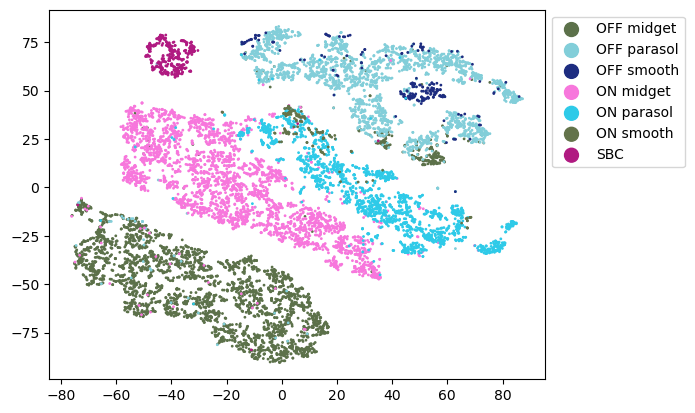

In [46]:
def generate_unique_color():
    return np.random.rand(3,)

labels = data['label'].values
label_colors = {label: generate_unique_color() for label in np.unique(labels)}
colors = np.array([label_colors[i] for i in labels])

for i,label in enumerate(np.unique(labels)):
    plt.scatter(acf_tc_tsne[labels==label,0],acf_tc_tsne[labels==label,1],s=1,c=colors[labels==label], label=label)
    # plt.scatter(cch_tsne[labels==label,0],cch_tsne[labels==label,1],s=1,c=colors[labels==label], label=label)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1),markerscale=10)

/Volumes/Lab/Development/miniconda-peggyo/envs/bhofflich-scpy/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


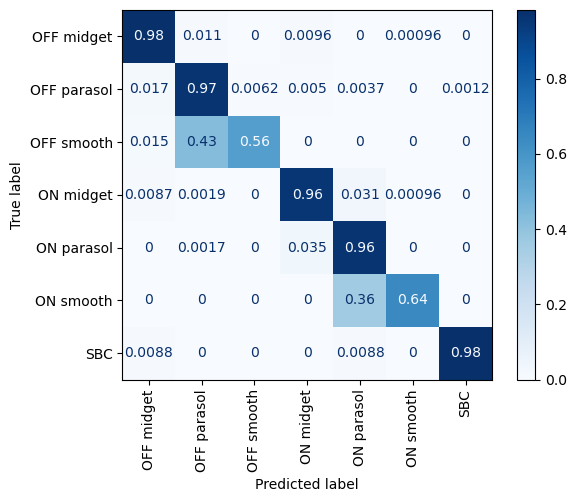

In [47]:
#SVM classification
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(np.hstack([acf_pca,tc_pca, tc_all_pca]), labels, test_size=0.33, random_state=42)

#Train the SVM
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)

#Test the SVM
y_pred = clf.predict(X_test)
plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, normalize='true', xticks_rotation='vertical')



In [49]:
from file_handling import wrapper
pc_data = {'piece_id': data['piece_id'].values,
           'run_id': data['run_id'].values,
           'unit_id': data['unit_id'].values,
           'tc': [wrapper(tc) for tc in tc_pca], 
           'tc_all': [wrapper(tc) for tc in tc_all_pca], 
           'acf': [wrapper(acf) for acf in acf_pca],
           'cch_1ms': [wrapper(cch) for cch in transformed_cch_1ms_matrices],
           'cch_10ms': [wrapper(cch) for cch in transformed_cch_10ms_matrices],
           'spike_waveform': [wrapper(swf) for swf in spike_waveforms_pca],
           'label': data['label'].values, 
           'rf_size': np.sqrt(data['size'].values/np.pi),
           'spike_count': data['spike_count'].values,
           'distance': data['distances'].values,
           'overlap': data['overlaps'].values,
           'cch_ids': data['cch_ids'].values,}
gnn_data = pd.DataFrame(pc_data)

In [50]:
# gnn_data = pickle.load(open('/Volumes/Scratch/Users/bhofflic/cell_correlations/gnn_data/gnn_data.pkl', 'rb'))
gnn_data.to_pickle('/Volumes/Scratch/Users/bhofflic/cell_correlations/gnn_data/gnn_data.pkl')

In [74]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)

edge_tsne = tsne.fit_transform(np.array(node_features))

/Volumes/Lab/Development/miniconda-peggyo/envs/bhofflich-scpy/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Volumes/Lab/Development/miniconda-peggyo/envs/bhofflich-scpy/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


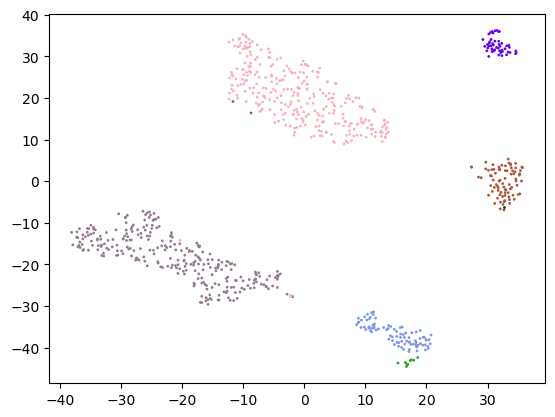

In [75]:
def generate_unique_color():
    return np.random.rand(3,)

labels = np.array(piece_gnn_data['label'])
label_colors = {label: generate_unique_color() for label in np.unique(labels)}
colors = np.array([label_colors[i] for i in labels])

for i,label in enumerate(np.unique(labels)):
    mask = labels == label
    filtered_edge_tsne = edge_tsne[mask]
    plt.scatter(filtered_edge_tsne[:,0],filtered_edge_tsne[:,1],s=1,c=colors[mask], label=label)
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1),markerscale=10)

/Volumes/Lab/Development/miniconda-peggyo/envs/bhofflich-scpy/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


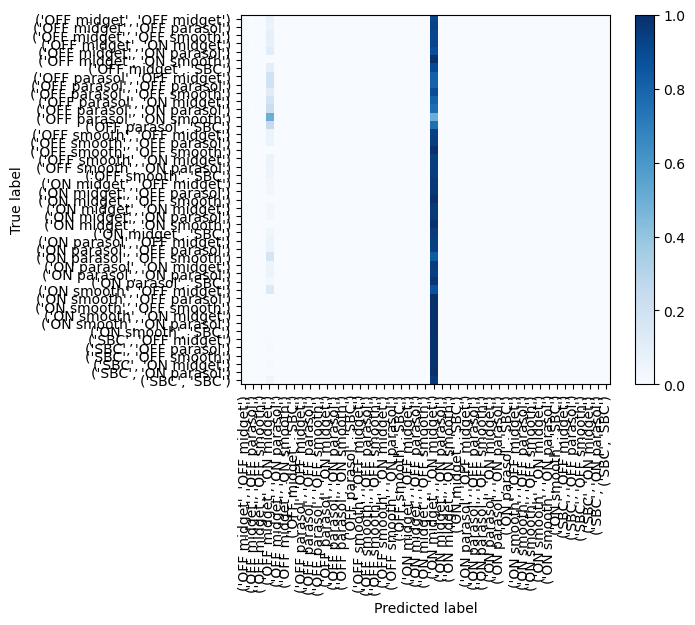

In [ ]:
#SVM classification
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

#Split the data into training and testing sets
#convert labels to strings
edge_labels = np.array([str(label) for label in edge_labels])
    
X_train, X_test, y_train, y_test = train_test_split(edge_features, edge_labels, test_size=0.30, random_state=42)

#Train the SVM
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)

#Test the SVM
y_pred = clf.predict(X_test)

plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, xticks_rotation='vertical', include_values=False, normalize='true')


In [ ]:
#accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.11656092402798113

Visualize Graph Structure

In [51]:
#create a neat networkx graph
import networkx as nx
import matplotlib.pyplot as plt

piece_id = gnn_data['piece_id'].unique()[0]
piece_gnn_data = gnn_data.query('piece_id == @piece_id')
G = nx.MultiGraph()
# Assuming the number of nodes is the shape of valid_cell_dists
num_nodes = len(piece_gnn_data)
G.add_nodes_from(range(num_nodes))
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        distance = piece_gnn_data['distance'].values[i].a[j]
        if distance > 3:
            continue
        edge_type = 'nonsurround' if distance < 1.5 else 'surround'
        edge_attributes = {
            'dist': distance,
            'edge_type': edge_type,
        }
        G.add_edge(i, j, **edge_attributes)

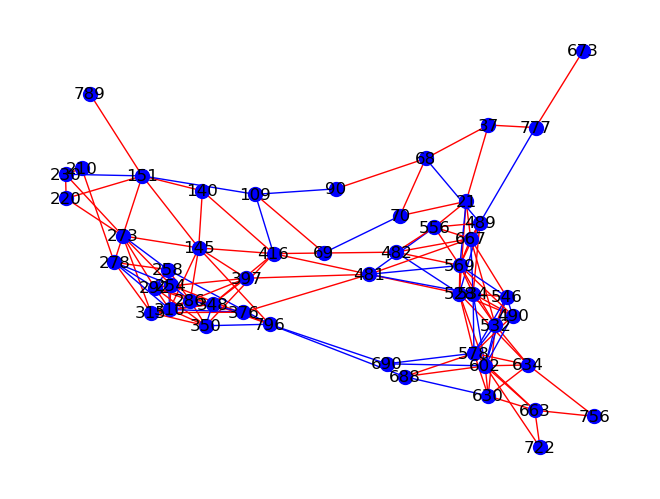

In [55]:
# Define colors for different edge types
edge_colors = {
    'surround': 'red',
    'nonsurround': 'blue'
}

# Create a list of edge colors based on edge types
edge_color_list = [edge_colors[G[u][v][0]['edge_type']] for u, v in G.edges()]

subgraph = G.subgraph(np.random.choice(G.nodes, 50, replace=False))
pos = nx.spring_layout(subgraph)
options = {
    'with_labels': True,
    'node_color': 'blue',
    'node_size': 100,
    'width': 1,
    'edge_color': edge_color_list,
}
nx.draw(subgraph, pos, **options)

Create PyG Model

In [56]:
edges = []
edge_features = []
edge_labels = []
piece_id = gnn_data['piece_id'].unique()[0]
piece_gnn_data = gnn_data.query('piece_id == @piece_id')
for i in range(piece_gnn_data.shape[0]):
    for j in range(i+1, piece_gnn_data.shape[0]):
        if piece_gnn_data['distance'].values[i].a[j] < 3:
            edges.append([i,j])
            edges.append([j,i])
            if piece_gnn_data['distance'].values[i].a[j] < 1.5:
                edge_type = 0
            else:
                edge_type = 1
            edge_features.append(np.hstack([edge_type,
                                            piece_gnn_data['distance'].values[i].a[j], 
                                            piece_gnn_data['overlap'].values[i].a[j], 
                                            piece_gnn_data['cch_1ms'].values[i].a[j], 
                                            piece_gnn_data['cch_10ms'].values[i].a[j]]))
            edge_features.append(np.hstack([edge_type,
                                            piece_gnn_data['distance'].values[j].a[i], 
                                            piece_gnn_data['overlap'].values[j].a[i], 
                                            piece_gnn_data['cch_1ms'].values[j].a[i], 
                                            piece_gnn_data['cch_10ms'].values[j].a[i]]))
            edge_labels.append((piece_gnn_data['label'].values[i], piece_gnn_data['label'].values[j]))
            edge_labels.append((piece_gnn_data['label'].values[j], piece_gnn_data['label'].values[i]))
edges = np.array(edges)
edge_features = np.array(edge_features)
edge_labels = np.array(edge_labels)

In [73]:
from sklearn.preprocessing import LabelEncoder

node_features = pd.concat([piece_gnn_data[['tc','tc_all','acf']].applymap(lambda x: x.a)], axis=1)
node_features = np.stack(node_features.apply(np.concatenate, axis=1).to_numpy())

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(piece_gnn_data['label'])

In [ ]:
import torch
from torch_geometric.data import Data
node_features_tensor = torch.tensor(node_features, dtype=torch.float)
labels_tensor = torch.tensor(labels, dtype=torch.long)
edge_index_tensor = torch.tensor(edges, dtype=torch.long).t().contiguous()
edge_features_tensor = torch.tensor(edge_features, dtype=torch.float)

data = Data(x=node_features_tensor, 
            edge_index=edge_index_tensor, 
            y=labels_tensor,
            edge_attr=edge_features_tensor)
data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.train_mask[:int(data.num_nodes*0.8)] = 1
data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.test_mask[int(data.num_nodes*0.8):] = 1
data

Data(x=[803, 20], edge_index=[2, 81960], edge_attr=[81960, 15], y=[803], train_mask=[803], test_mask=[803])

In [ ]:
import torch
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing

class CustomGNNLayer(MessagePassing):
    def __init__(self, in_channels, out_channels, num_edge_features):
        super(CustomGNNLayer, self).__init__(aggr='mean')  # mean aggregation
        # Linear transformation for combining node and edge features
        self.lin = torch.nn.Linear(in_channels + num_edge_features, out_channels)

    def forward(self, x, edge_index, edge_attr):
        # Start propagating messages
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x, edge_attr=edge_attr)

    def message(self, x_j, edge_attr):
        # x_j denotes neighboring node features, edge_attr denotes edge features
        tmp = torch.cat([x_j, edge_attr], dim=1)  # Concatenate node and edge features
        return self.lin(tmp)

class RGC_GNNModel(torch.nn.Module):
    def __init__(self, num_node_features, num_edge_features, num_classes):
        super(RGC_GNNModel, self).__init__()
        self.conv1 = CustomGNNLayer(num_node_features, 16, num_edge_features)
        self.conv2 = CustomGNNLayer(16, num_classes, num_edge_features)

    def forward(self, x, edge_index, edge_attr):
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index, edge_attr)
        return F.log_softmax(x, dim=1)

In [ ]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
print(f'Device: {device}, {torch.cuda.current_device()}')

Device: cpu, 0


In [ ]:
data = data.to(device)
model = RGC_GNNModel(num_node_features=20, num_edge_features=15, num_classes=7).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
NUM_EPOCHS = 10000

def evaluate(mask):
    model.eval()
    with torch.no_grad():
        logits = model(data.x, data.edge_index, data.edge_attr)
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
    return acc

train_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 10000
# Run the training process
for epoch in tqdm(range(num_epochs)):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_attr)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    train_acc = evaluate(data.train_mask)
    val_acc = evaluate(data.test_mask)
    if epoch % 100 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
    train_losses.append(loss.cpu().detach().numpy())
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

# Evaluate on the test set
test_acc = evaluate(data.test_mask)
print(f'Test Accuracy: {test_acc:.4f}')

  0%|          | 4/10000 [00:00<05:28, 30.39it/s]

Epoch: 000, Loss: 493.5279, Train Acc: 0.1184, Val Acc: 0.0621


  1%|          | 106/10000 [00:02<04:28, 36.81it/s]

Epoch: 100, Loss: 1.4787, Train Acc: 0.3396, Val Acc: 0.3913


  2%|▏         | 206/10000 [00:05<04:35, 35.60it/s]

Epoch: 200, Loss: 1.4563, Train Acc: 0.3551, Val Acc: 0.4161


  3%|▎         | 306/10000 [00:08<04:19, 37.31it/s]

Epoch: 300, Loss: 1.4717, Train Acc: 0.3645, Val Acc: 0.4472


  4%|▍         | 406/10000 [00:11<05:14, 30.53it/s]

Epoch: 400, Loss: 1.4447, Train Acc: 0.3645, Val Acc: 0.4099


  5%|▌         | 508/10000 [00:14<04:25, 35.82it/s]

Epoch: 500, Loss: 1.4466, Train Acc: 0.3660, Val Acc: 0.4348


  6%|▌         | 607/10000 [00:17<04:20, 36.12it/s]

Epoch: 600, Loss: 1.4395, Train Acc: 0.3660, Val Acc: 0.4286


  7%|▋         | 707/10000 [00:20<04:11, 36.89it/s]

Epoch: 700, Loss: 1.4378, Train Acc: 0.3645, Val Acc: 0.4224


  8%|▊         | 804/10000 [00:23<05:23, 28.46it/s]

Epoch: 800, Loss: 1.4360, Train Acc: 0.3660, Val Acc: 0.4410


  9%|▉         | 907/10000 [00:26<05:02, 30.02it/s]

Epoch: 900, Loss: 1.4350, Train Acc: 0.3660, Val Acc: 0.4410


 10%|█         | 1007/10000 [00:29<03:58, 37.78it/s]

Epoch: 1000, Loss: 1.4341, Train Acc: 0.3645, Val Acc: 0.4224


 11%|█         | 1107/10000 [00:32<03:55, 37.72it/s]

Epoch: 1100, Loss: 1.4332, Train Acc: 0.3707, Val Acc: 0.4161


 12%|█▏        | 1208/10000 [00:34<03:53, 37.68it/s]

Epoch: 1200, Loss: 1.4324, Train Acc: 0.3707, Val Acc: 0.4161


 13%|█▎        | 1308/10000 [00:37<03:45, 38.62it/s]

Epoch: 1300, Loss: 1.4315, Train Acc: 0.3660, Val Acc: 0.4224


 14%|█▍        | 1405/10000 [00:39<03:47, 37.81it/s]

Epoch: 1400, Loss: 1.4307, Train Acc: 0.3676, Val Acc: 0.4224


 15%|█▌        | 1506/10000 [00:42<03:45, 37.66it/s]

Epoch: 1500, Loss: 1.4299, Train Acc: 0.3723, Val Acc: 0.4224


 16%|█▌        | 1607/10000 [00:45<04:44, 29.55it/s]

Epoch: 1600, Loss: 1.4291, Train Acc: 0.3707, Val Acc: 0.4286


 16%|█▋        | 1638/10000 [00:46<03:58, 35.08it/s]


KeyboardInterrupt: 

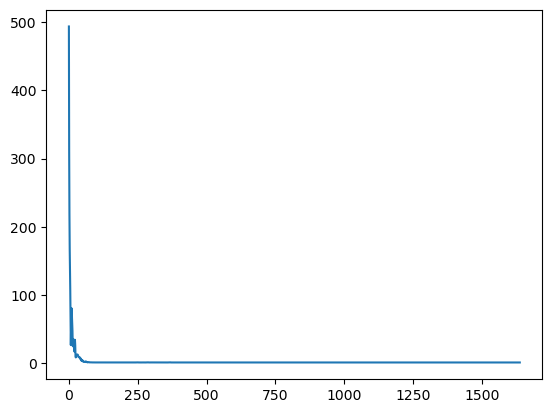

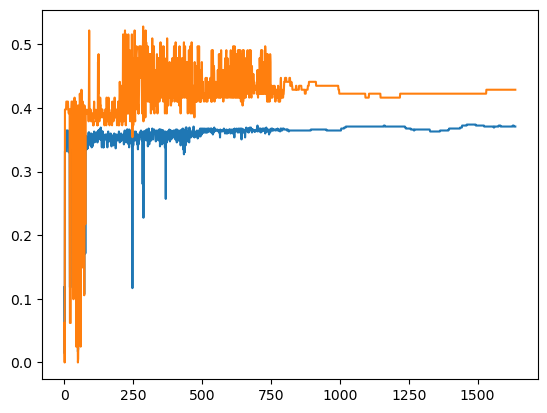

In [ ]:
plt.plot(np.array(train_losses))
plt.figure()
plt.plot(np.array(train_accuracies))
plt.plot(np.array(val_accuracies))